# Objective

In this Kernel I am doing EDA on [dataset](https://www.kaggle.com/c/nlp-getting-started/data) provided for classification of Disaster Tweets [competition](https://www.kaggle.com/c/nlp-getting-started/overview) . For classification I will be using different classifier model along with Natural Language Processing Techniques for analyzing sentiments in tweets.For submission will evaluate different models based on Accuracy and F1 Score.

As this is my first NLP work I tried to keep this notebook simple and easy to understand for beginner. If you like the kernel **please upvote**.

# Data Exploration

Let's start with importing required libraries and dataset

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
#Importing the required libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

#Importing required libraries fo cleaning text
import re
import nltk
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

print("Important libraries loaded successfully")

In [ ]:
ds_train=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
ds_test=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
print("Train and Test data sets are imported successfully")

In [ ]:
#Checking number of records in train data set and few records from train data set
print("Number of records in Train data set",len(ds_train.index))
ds_train.head()

Looks like some values from 'Keyword' and 'Location' columns are missing let's explore these columns

In [ ]:
#Distinct keywords in train dataset
dist_keyword=ds_train['keyword'].value_counts()
dist_keyword

In [ ]:
#Visualize the keywords
fig = px.scatter(dist_keyword, x=dist_keyword.values, y=dist_keyword.index,size=dist_keyword.values)
fig.show()

In [ ]:
#Distinct location in train dataset
dist_location=ds_train['location'].value_counts()
#Visualize location
fig = px.scatter(dist_location, y=dist_location.values, x=dist_location.index,size=dist_location.values)
fig.show()

Let's check how many missing values are there 'Location' and 'Keyword' columns

In [ ]:
# creating bool series True for NaN values for location 
bool_series_location = pd.isnull(ds_train['location']) 

# filtering data  
# displaying data only with location = NaN  
ds_train[bool_series_location]
print("Number of records with missing location",len(ds_train[bool_series_location]))

In [ ]:
# creating bool series True for NaN values  
bool_series_keyword = pd.isnull(ds_train['keyword']) 
# filtering data  
# displaying data only with Keywords = NaN  
ds_train[bool_series_keyword]
print("Number of records with missing keywords",len(ds_train[bool_series_keyword]))

In [ ]:
# Calculate percentage of missing keywords
print('{}% of Kewords are missing from Total Number of Records'.format((len(ds_train[bool_series_keyword])/len(ds_train.index))*100))

From Data description and above analysis we can conclude :

* Locations are not automatically generated, they are user inputs and that's why data is not clean and there are too many incoorect and missing values.We can skip the 'location' column from our feature list

* We can consider the 'keyword' column as a feature because there are a lot of unique keywords and missing values are very insignificant (< 1 percentage)

In [ ]:
#dropping unwanted column 'location'
ds_train=ds_train.drop(['location'],axis=1)
ds_train.head()

In [ ]:
#dropping missing 'keyword' records from train data set
ds_train=ds_train.drop(ds_train[bool_series_keyword].index,axis=0)
#Resetting the index after droping the missing records
ds_train=ds_train.reset_index(drop=True)
print("Number of records after removing missing keywords",len(ds_train))
ds_train.head()

# Data Preprocessing: Basic NLP Techniques

Let's create Corpus from 'Text' coloumn, **Corpus** is a simplified version of our text data that contain clean data. To create Corpus we have to perform the following actions

1.  **Remove unwanted words** : Removal of unwanted words such as **special characters** and **numbers** to get only pure text
1.  **Transform words to lowercase** : Transform words to lowercase because upper and lower case have diffirent **ASCII** codes
1. **Remove stopwords** : Stop words are usually the most common words in a language and they will be irrelevant in determining the nature
1.  **Stemming words** : Stemming is the process of reducing words to their word stem, base or root form


In [ ]:
corpus  = []
pstem = PorterStemmer()
for i in range(ds_train['text'].shape[0]):
    #Remove unwanted words
    text = re.sub("[^a-zA-Z]", ' ', ds_train['text'][i])
    #Transform words to lowercase
    text = text.lower()
    text = text.split()
    #Remove stopwords then Stemming it
    text = [pstem.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    #Append cleaned tweet to corpus
    corpus.append(text)
    
print("Corpus created successfully")  

It's quiet evident that some words occured very less in tweets, so we can remove these words from our corpus to decrease dimension of 'Bag of World' model

We will create a dictionary for this where 'key' refer to a word and 'value' refer to frequency of that word in tweets and data frame from that dictionary

In [ ]:
#Create dictionary 
uniqueWords = {}
for text in corpus:
    for word in text.split():
        if(word in uniqueWords.keys()):
            uniqueWords[word] += 1
        else:
            uniqueWords[word] = 1
            
#Convert dictionary to dataFrame
uniqueWords = pd.DataFrame.from_dict(uniqueWords,orient='index',columns=['WordFrequency'])
uniqueWords.sort_values(by=['WordFrequency'], inplace=True, ascending=False)
print("Number of records in Unique Words Data frame are {}".format(len(uniqueWords)))
uniqueWords.head(10)


In [ ]:
#Get Maximum,Minimum and Mean occurance of a word 
print("Maximum Occurance of a word is {} times".format(uniqueWords['WordFrequency'].max()))
print("Minimum Occurance of a word is {} times".format(uniqueWords['WordFrequency'].min()))
print("Mean Occurance of a word is {} times".format(uniqueWords['WordFrequency'].mean()))

From 'unique words' data frame we can say that some words are repeated lot and some repeated very less , we can only keep words which are occuring 20 times or more to keep the dimension of Bag of world model reasonable.

In [ ]:
uniqueWords=uniqueWords[uniqueWords['WordFrequency']>=20]
print("Number of records in Unique Words Data frame are {}".format(len(uniqueWords)))

As you can see the number of records have reduced drastically.

Let's create Word cloud for our corpus

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(" ".join(corpus))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

Let's create Bag of word model (Sparse Matrix), it contains only unique words from corpus.

In [ ]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = len(uniqueWords))
#Create Bag of Words Model , here X represent bag of words
X = cv.fit_transform(corpus).todense()
y = ds_train['target'].values

Here, in our feature list, we have not added the 'keyword' column because the value of this column must be there in the corpus and eventually in Bag of Words model so we can skip this.

# Data Modeling and Model Evaluation

Let's build our models , will try different models and evaluate each of them.

We will be using **confusion matrix** to evaluate them. Confusion matrix is formed from the four outcomes produced as a result of binary classification
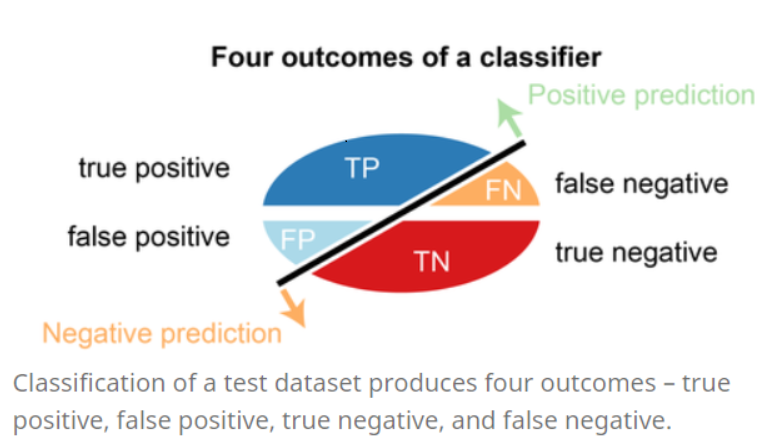

It's a binary classifier predicts all data instances of a test dataset as either positive or negative. This classification (or prediction) produces four outcomes – true positive, true negative, false positive and false negative.

* True positive (TP): correct positive prediction
* False positive (FP): incorrect positive prediction
* True negative (TN): correct negative prediction
* False negative (FN): incorrect negative prediction

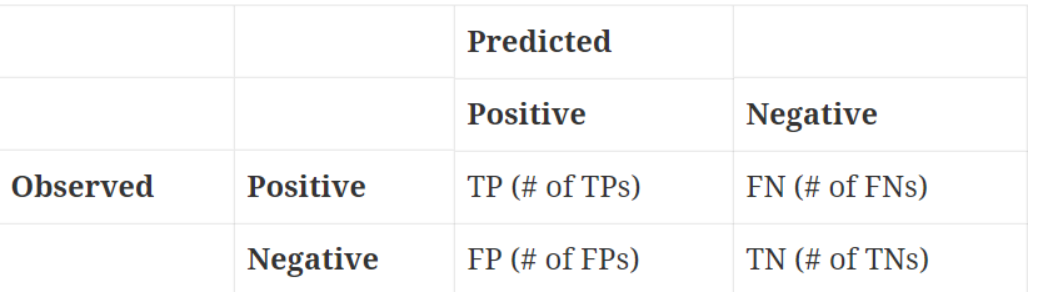

Also , we can calulate **F1 score** for all models .

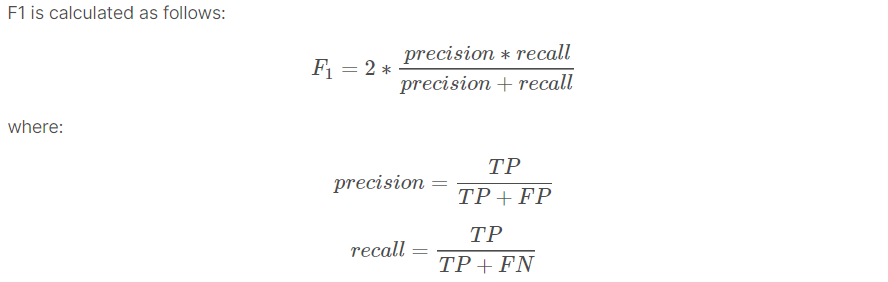

In [ ]:
#Split the train data set to train and test data
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2, random_state=2020)
print('Train Data splitted successfully')

Let's start with **Gaussian Naive Bayes** Model

In [ ]:
# Fitting Gaussian Naive Bayes to the Training set
classifier_gnb = GaussianNB()
classifier_gnb.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_gnb = classifier_gnb.predict(X_test)
# Making the Confusion Matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
cm_gnb

Let's calcualte Model Accuracy Score and F1 score

In [ ]:
#Calculating Model Accuracy
print('GaussianNB Classifier Accuracy Score is {} for Train Data Set'.format(classifier_gnb.score(X_train, y_train)))
print('GaussianNB Classifier Accuracy Score is {} for Test Data Set'.format(classifier_gnb.score(X_test, y_test)))
print('GaussianNB Classifier F1 Score is {}'.format(f1_score(y_test, y_pred_gnb)))


**Gradient Boosting Model**

In [ ]:
# Fitting Gradient Boosting Models to the Training set
classifier_gb = GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 100,
                                                   max_depth = 30,
                                                   random_state=55)
classifier_gb.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_gb = classifier_gb.predict(X_test)
# Making the Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_gb

In [ ]:
#Calculating Model Accuracy
print('Gradient Boosting Classifier Accuracy Score is {} for Train Data Set'.format(classifier_gb.score(X_train, y_train)))
print('Gradient Boosting Classifier Accuracy Score is {} for Test Data Set'.format(classifier_gb.score(X_test, y_test)))
print('Gradient Boosting Classifier F1 Score is {} '.format(f1_score(y_test, y_pred_gb)))


**K - Nearest Neighbors Model**

In [ ]:
# Fitting K- Nearest neighbour to the Training set
classifier_knn = KNeighborsClassifier(n_neighbors = 7,weights = 'distance',algorithm = 'brute')
classifier_knn.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_knn = classifier_knn.predict(X_test)
# Making the Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn

In [ ]:
#Calculating Model Accuracy
print('K-Nearest Neighbour Model Accuracy Score for Train Data set is {}'.format(classifier_knn.score(X_train, y_train)))
print('K-Nearest Neighbour Model Accuracy Score for Test Data set is {}'.format(classifier_knn.score(X_test, y_test)))
print('K-Nearest Neighbour Model F1 Score is {}'.format(f1_score(y_test, y_pred_knn)))

**Decision Tree Model**

In [ ]:
# Fitting Decision Tree Models to the Training set
classifier_dt = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = None, 
                                           splitter='best', 
                                           random_state=55)
classifier_dt.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_dt = classifier_dt.predict(X_test)
# Making the Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_dt

In [ ]:
#Calculating Model Accuracy
print('DecisionTree Model Accuracy Score for Train Data set is {}'.format(classifier_dt.score(X_train, y_train)))
print('DecisionTree Model Accuracy Score for Test Data set is {}'.format(classifier_dt.score(X_test, y_test)))
print('DecisionTree Model F1 Score is {}'.format(f1_score(y_test, y_pred_dt)))

**Logistic Regression Model**

In [ ]:
# Fitting Logistic Regression Model to the Training set
classifier_lr = LogisticRegression()
classifier_lr.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_lr = classifier_lr.predict(X_test)
# Making the Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr

In [ ]:
#Calculating Model Accuracy
print('Logistic Regression Model Accuracy Score for Train Data set is {}'.format(classifier_lr.score(X_train, y_train)))
print('Logistic Regression Model Accuracy Score for Test Data set is {}'.format(classifier_lr.score(X_test, y_test)))
print('Logistic Regression Model F1 Score is {}'.format(f1_score(y_test, y_pred_lr)))

**XGBOOST**

In [ ]:
# Fitting XGBoost Model to the Training set
classifier_xgb = XGBClassifier(max_depth=6,learning_rate=0.3,n_estimators=1500,objective='binary:logistic',random_state=123,n_jobs=4)
classifier_xgb.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_xgb = classifier_xgb.predict(X_test)
# Making the Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_xgb

In [ ]:
print('XG Boost Model Accuracy Score for Train Data set is {}'.format(classifier_xgb.score(X_train, y_train)))
print('XG Boost Model Accuracy Score for Test Data set is {}'.format(classifier_xgb.score(X_test, y_test)))
print('XG Boost Model F1 Score is {}'.format(f1_score(y_test, y_pred_xgb)))

**Multinomial Naive Bayes**

In [ ]:
# Fitting multinomial naive bayes Model to the Training set
classifier_mnb = MultinomialNB()
classifier_mnb.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_mnb = classifier_mnb.predict(X_test)
# Making the Confusion Matrix
cm_mnb = confusion_matrix(y_test, y_pred_mnb)
cm_mnb

In [ ]:
print('MultinomialNB Model Accuracy Score for Train Data set is {}'.format(classifier_mnb.score(X_train, y_train)))
print('MultinomialNB Model Accuracy Score for Test Data set is {}'.format(classifier_mnb.score(X_test, y_test)))
print('MultinomialNB Model F1 Score is {}'.format(f1_score(y_test, y_pred_mnb)))

> Multinomial Naive Bayes is giving best score out of all models i.e. **0.76**

**Voting Classifier Model**

A Voting classifier model combines multiple different models (i.e., sub-estimators) into a single model, which is (ideally) stronger than any of the individual models alone

In [ ]:
# Fitting Logistic Regression Model to the Training set
models = [('LogisticRegression',classifier_lr),
                ('XGBoost Classifier',classifier_xgb),
         ('DecisionTree Classifier',classifier_dt),
         ('K-Nerarest Neighbour', classifier_knn),
         ('Gradient Boosting',classifier_gb),
         ('Gaussian Naive Bayes',classifier_gnb),
         ('MultinomialNB',classifier_mnb)]
classifier_vc = VotingClassifier(voting = 'hard',estimators= models)
classifier_vc.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_vc = classifier_dt.predict(X_test)
# Making the Confusion Matrix
cm_vc = confusion_matrix(y_test, y_pred_vc)
cm_vc

In [ ]:
#Calculating Model Accuracy
print('Voting Classifier Model Accuracy Score for Train Data set is {}'.format(classifier_vc.score(X_train, y_train)))
print('Voting Classifier Model Accuracy Score for Test Data set is {}'.format(classifier_vc.score(X_test, y_test)))
print('Voting Classifier Model F1 Score is {}'.format(f1_score(y_test, y_pred_vc)))

Let's start working on Test Data set

# Prediction for Test Data and Submission

In [ ]:
#Check number of records in Test Data set
print("Number of records present in Test Data Set are {}".format(len(ds_test.index)))
#Check number of missing Keywords in Test Data set
print("Number of records without keywords in Test Data are {}".format(len(ds_test[pd.isnull(ds_test['keyword'])])))
print("Number of records without location in Test Data are {}".format(len(ds_test[pd.isnull(ds_test['location'])])))

As similar to Train data number of missing location are more and remaining values are also not unique/correct to keep in the feature list, will drop 'location' column

We will keep the rows corresponds to missing 'keyword'  because the deletion of records will affect the submission file.

In [ ]:
#Drop Location column from Test Data
ds_test=ds_test.drop(['location'],axis=1)
ds_test.head()

In [ ]:
#Fitting into test set
X_testset=cv.transform(ds_test['text']).todense()

In [ ]:
#Predict data with classifier created in previous section
y_test_pred_gnb = classifier_gnb.predict(X_testset)
y_test_pred_gb = classifier_gb.predict(X_testset)
y_test_pred_dt = classifier_dt.predict(X_testset)
y_test_pred_knn = classifier_knn.predict(X_testset)
y_test_pred_lr = classifier_lr.predict(X_testset)
y_test_pred_vc = classifier_vc.predict(X_testset)
y_test_pred_xgb = classifier_xgb.predict(X_testset)
y_test_pred_mnb = classifier_mnb.predict(X_testset)

In [ ]:
#Fetching Id to differnt frame
y_test_id=ds_test[['id']]
#Converting Id into array
y_test_id=y_test_id.values
#Converting 2 dimensional y_test_id into single dimension 
y_test_id=y_test_id.ravel()

In [ ]:
#Converting 2 dimensional y_test_pred for all predicted results into single dimension 
y_test_pred_gnb=y_test_pred_gnb.ravel()
y_test_pred_gb=y_test_pred_gb.ravel()
y_test_pred_dt=y_test_pred_dt.ravel()
y_test_pred_knn=y_test_pred_knn.ravel()
y_test_pred_lr=y_test_pred_lr.ravel()
y_test_pred_vc=y_test_pred_vc.ravel()
y_test_pred_xgb=y_test_pred_xgb.ravel()
y_test_pred_mnb=y_test_pred_mnb.ravel()

In [ ]:
#Creating Submission dataframe
submission_df_gnb=pd.DataFrame({"id":y_test_id,"target":y_test_pred_gnb})
submission_df_gb=pd.DataFrame({"id":y_test_id,"target":y_test_pred_gb})
submission_df_dt=pd.DataFrame({"id":y_test_id,"target":y_test_pred_dt})
submission_df_knn=pd.DataFrame({"id":y_test_id,"target":y_test_pred_knn})
submission_df_lr=pd.DataFrame({"id":y_test_id,"target":y_test_pred_lr})
submission_df_vc=pd.DataFrame({"id":y_test_id,"target":y_test_pred_vc})
submission_df_xgb=pd.DataFrame({"id":y_test_id,"target":y_test_pred_xgb})
submission_df_mnb=pd.DataFrame({"id":y_test_id,"target":y_test_pred_mnb})



#Setting index as Id Column
submission_df_gnb.set_index("id")
submission_df_gb.set_index("id")
submission_df_dt.set_index("id")
submission_df_knn.set_index("id")
submission_df_lr.set_index("id")
submission_df_vc.set_index("id")
submission_df_xgb.set_index("id")
submission_df_mnb.set_index("id")

In [ ]:
#Converting into CSV file for submission
submission_df_gnb.to_csv("submission_gnb.csv",index=False)
submission_df_gb.to_csv("submission_gb.csv",index=False)
submission_df_dt.to_csv("submission_dt.csv",index=False)
submission_df_knn.to_csv("submission_knn.csv",index=False)
submission_df_lr.to_csv("submission_lr.csv",index=False)
submission_df_vc.to_csv("submission_vc.csv",index=False)
submission_df_xgb.to_csv("submission_xgb.csv",index=False)
submission_df_mnb.to_csv("submission_mnb.csv",index=False)

Out of all these models I am getting my best score  which is **~0.76** from Multinomial Naive Bayes Model . This could be improved further.

### If you like the kernel please upvote